In [1]:
%load_ext autoreload
%autoreload 2

import os
import matplotlib.pyplot as plt
plt.rcParams['font.size'] = 12
import seaborn as sns
sns.set_style('darkgrid')
import numpy as np
from time import time
from tqdm import tqdm
import pandas as pd
from collections import OrderedDict

from utils import generator, online_matchmaking, metrics, optimizers, actions, obj_functions, dyn_systems
from utils.base import Resource
import const_define as cd

## Generate data

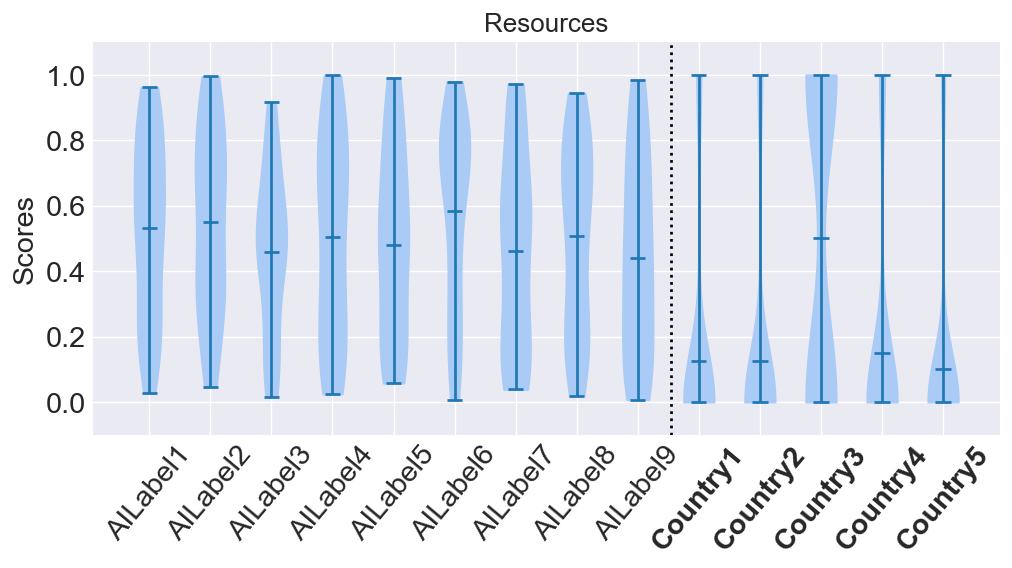

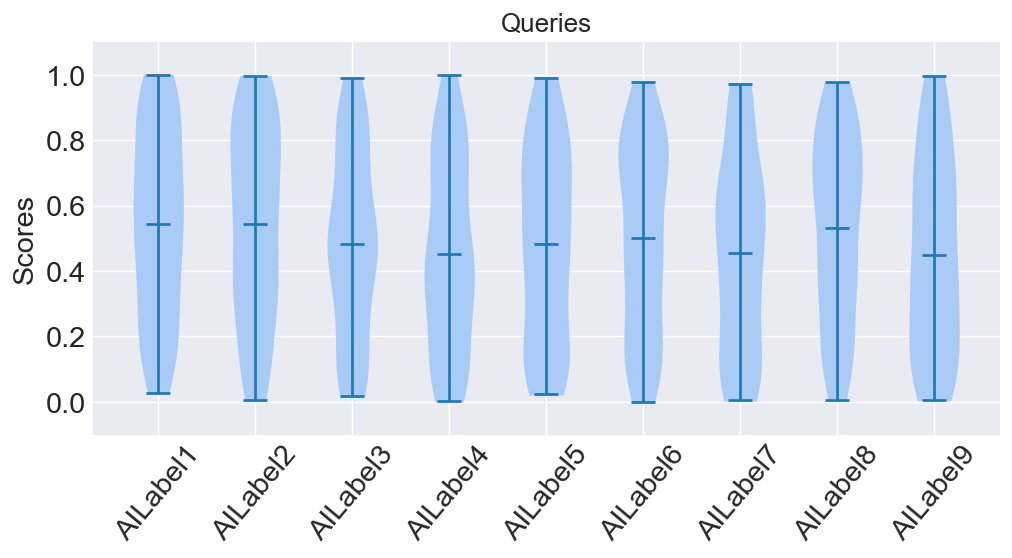

In [3]:
seed=8888
dataset = 'balanced'

labelsAI = {i:f'AILabel{i+1}'for i in range(9)}
n_labelsAI= len(labelsAI)
countries = {i+n_labelsAI:f'Country{i+1}'for i in range(5)}
n_countries= len(countries)
r_rank, q_rank = None, None

# Balanced
if dataset == 'balanced':
    r_countries = (1/len(countries),) * len(countries)
# Mild Unbalanced
elif dataset == 'mild_unbalanced':
    r_countries = (0.125, 0.125, 0.5, 0.125, 0.125)
# Strong Unbalanced
elif dataset == 'strong_unbalanced':
    r_countries = (0.05, 0.05, 0.8, 0.05, 0.05)
else:
    raise ValueError()

g = generator.StrwaiDataGenerator(labelsAI,
                        countries,
                        r_rank=r_rank,
                        r_countries=r_countries,
                        seed=seed)


n_resources = 40
n_queries = 100
queries_scores, resources_scores = g.generate_data(n_queries, n_resources)
g.plot_data(queries_scores, resources_scores, name=dataset, save=True)


## Compute DIDI over all the queries output

In [24]:
# Create Resources
resources_ids = list(range(len(resources_scores)))
resources_names = [f'res_{i}' for i in resources_ids]
resources_descr = [f'descr_{i}' for i in resources_ids]
resources_scores_dict = [{str(l): resources_scores[i, l] for l in range(n_labelsAI+n_countries)} for i in resources_ids]

resources_list = [Resource(name=resources_names[i], identifier=resources_ids[i], description=resources_descr[i],
                           scores=resources_scores_dict[i]) for i in resources_ids]
# Create Quieries
queries_scores_list = [{str(l): queries_scores[i, l] for l in range(n_labelsAI+n_countries)} for i in
                       range(len(queries_scores))]
# Country flag
resources_countries = resources_scores[:, n_labelsAI:]

# Define matching algorithm
matching_metrics = online_matchmaking.CosineSimilarityScore()
mm_alg = online_matchmaking.OnlineMatchmaking(matching_metrics)
mm_alg.loadResources(resources_list)
# Define DIDI metrics
didi_obj = metrics.DIDI(resources_countries, range(n_countries), impact_function=metrics.negative_exponential)

# Number of previous queries to consider to approximate the random variable q \sim P(Q_t)
N = 5
didi_list = []
rank_list = []
# Loop over the queries
counter = 0
for q in tqdm(queries_scores_list):
    # Compute original rank r of Resources resulting from q
    true_rank = mm_alg.matchOne(query_scores=q)
    # Storing the rank
    rank_list.append(true_rank)
    # Compute metrics 
    if counter >= N:
        didi = didi_obj(rank_list[-N:],
                        old_ranks = None)
        didi_list.append(didi)
    counter +=1
print(f'DIDI on {dataset} dataset:', np.mean(didi_list))

100%|███████████████████████████████████████| 100/100 [00:00<00:00, 2365.36it/s]

DIDI on balanced dataset: 1.702358904280333


## Test with Different Thresholds

In [25]:
records = {}
path = os.path.join(cd.PROJECT_DIR,'records', f'{dataset}/')
imgpath = os.path.join(cd.PROJECT_DIR,'images', f'{dataset}/')
records_list = ['true_rank',  # true rank (unmodified output of the matchmaking alg)
                'actioned_rank', # rank resulting from the application of the the actions found in the previous search to the true rank
                'provided_metrics',  # metrics of the actioned rank (which is the one provided to the user)
                'approx_metrics', # metrics of the approximated rank (it's obtained by applying the actions found in the current search to the actioned rank)
                'state', # record of the dynamical system evolution for each query (it's equal to the metrics itself if no search was performed)
                'cost_fn']  # approximation error (it's equal to -1 if no search was performed)

for file in records_list:
    fname = os.path.join(path,file + '.pkl')
    # Load existing records (if any)
    if os.path.isfile(fname):
        records[file] = pd.read_pickle(fname)
        print(f'Records loaded for {file}, with {len(records[file])} experiments')
    else:
        print(f'No records found for {file} in {path}')
        records[file] = {}

No records found for true_rank in /Users/eleonoramisino/Github/FAiRDAS/records/balanced/
No records found for actioned_rank in /Users/eleonoramisino/Github/FAiRDAS/records/balanced/
No records found for provided_metrics in /Users/eleonoramisino/Github/FAiRDAS/records/balanced/
No records found for approx_metrics in /Users/eleonoramisino/Github/FAiRDAS/records/balanced/
No records found for state in /Users/eleonoramisino/Github/FAiRDAS/records/balanced/
No records found for cost_fn in /Users/eleonoramisino/Github/FAiRDAS/records/balanced/


In [26]:
# Re-run experiment?
re_run = False
id_exp = 2
for file in records_list:
    if re_run:
        records[file].pop(id_exp)
        print('removed experiment:',id_exp)

In [27]:
# Define matching algorithm
matching_metrics = online_matchmaking.CosineSimilarityScore()
mm_alg = online_matchmaking.OnlineMatchmaking(matching_metrics)
mm_alg.loadResources(resources_list)
# Creating DIDI metrics object
didi_obj = metrics.DIDI(resources_countries, range(n_countries), impact_function=metrics.negative_exponential)


# Define desired dynamical behaviour
A = np.array([[0.5, 0.],
              [0., 0.5]])
# Fairness thresholds
# DIDI and rank distance
mu_dict = {0:np.array([np.inf, np.inf]),
            1:np.array([0., np.inf]),
           2:np.array([5., 0.3]),
          3:np.array([2., 0.3]),
          4:np.array([1., 0.1])} 

for file in records_list:
    if not isinstance(records[file],dict):
        records[file] = records[file].to_dict()
for mu in mu_dict:
    if mu in records['true_rank'].keys():
        print('Already existing experiment')
        continue
    else:
        print(f'Test framework with threshold conf. No. {mu}')

        dyn_sys = dyn_systems.DynSystemMin(A, mu)
        records[file][mu] = {} 
            
        cd.set_seed(seed)
        # Creating DIDI metrics object
        didi_obj = metrics.DIDI(resources_countries, range(n_countries),
                                impact_function=metrics.negative_exponential)

        # Define the metrics
        metrics_dict = OrderedDict(DIDI=didi_obj,
                                   rank_dist=metrics.rank_similarity)
        metrics_obj = metrics.Metrics(metrics_dict, seed=seed)
        args_metrics = {k: {} for k in metrics_obj.metrics_dict}

        # Define objective function
        obj_fn = obj_functions.obj_fn_l2_wHistory
        # Define args for obj function
        metrics_weight = {'DIDI': 1.,
                          'rank_dist': 1.}

        obj_fn_args = {'resources_list': resources_list,
                       'metrics': metrics_obj,
                       'args_metrics': args_metrics,
                       'metrics_weight': metrics_weight}

        # Define searching algorithm
        max_iter = 200
        patience = 20
        tolerance = 1e-4
        rnd_search = optimizers.RandomWalk_wHistory(max_iter=max_iter,
                                                    n_samples=10,
                                                    decay_rate=0.04,
                                                    cost_fn=obj_fn,
                                                    patience=patience,
                                                    tolerance=tolerance,
                                                    seed=seed,
                                                    verbose=False)

        for file in records_list:
            if file in ['provided_metrics', 'approx_metrics']:
                records[file][mu] = {name: [] for name in metrics_obj.metrics_dict}
            else:
                records[file][mu] = []

        # We assume to not modify the very first query rank
        previous_flagged_resources = np.zeros((len(resources_list),), )

        # Loop over the queries
        counter = 0
        for q in tqdm(queries_scores_list):
            # 1) Compute original rank r of Resources resulting from q
            true_rank = OrderedDict(mm_alg.matchOne(query_scores=q))
            records['true_rank'][mu].append(true_rank)
            # 2) Perform actions
            # Change flag of resources
            resources_list_flagged = [Resource(name=resources_list[i].name,
                                               identifier=resources_list[i].identifier,
                                               description=resources_list[i].description,
                                               scores=resources_list[i].scores,
                                               at_bottom_flag=previous_flagged_resources[i]) for i in
                                      range(len(previous_flagged_resources))]
            # Put at the bottom
            actioned_rank, _ = actions.at_bottom([true_rank], resources_list_flagged)
            for r in actioned_rank:
                records['actioned_rank'][mu].append(r)


            # Compute metrics 
            if counter >= N:
                # 3) Compute metrics with rank and actioned rank
                m = np.zeros((metrics_obj.n_metrics,))
                for i, name in enumerate(metrics_obj.metrics_dict):
                    m[i] = metrics_obj.metrics_dict[name](records['actioned_rank'][mu][-N:],
                                                          records['true_rank'][mu][-N:], **args_metrics[name])
                    records['provided_metrics'][mu][name].append(m[i])

                # 4) If metrics > \mu, select resources to put at the bottom
                if not np.all(m <= mu_dict[mu]):
                    # print(m)
                    # print(mu_dict[mu])
                    # 5) Random search over \theta to minimize
                    # the distance between the metrics with the new rank and the expected behaviour A

                    # Compute dynamical state to approximate
                    x = dyn_sys(m)
                    records['state'][mu].append(x)
                    # Define starting point for search
                    w0 = np.random.choice(a=[0, 1], size=(len(resources_list),), p=[0.5, 0.5])

                    # Define args for obj function
                    obj_fn_args['x'] = x,
                    obj_fn_args['ranks'] = records['actioned_rank'][mu][-N:]
                    # Searching
                    flag_history, cost_history, flipping_probs, k = rnd_search(flag=w0,
                                                                               args=obj_fn_args)

                    # Update set of actions
                    previous_flagged_resources = flag_history[-1]
                    # Store results
                    cost = cost_history[-1][0]
                    x_approx = cost_history[-1][1]
                    for i, name in enumerate(metrics_obj.metrics_dict):
                        records['approx_metrics'][mu][name].append(x_approx[i])
                    records['cost_fn'][mu].append(cost)
                else:
                    # There has been no approximation process, thus no update is needed for the actions
                    # and the approx metrics is exaclty the real one
                    for i, name in enumerate(metrics_obj.metrics_dict):
                        records['approx_metrics'][mu][name].append(m[i])
                    records['state'][mu].append(m)
                    records['cost_fn'][mu].append(-1)
            counter += 1


Test framework with threshold conf. No. 0


100%|████████████████████████████████████████| 100/100 [00:00<00:00, 837.31it/s]


Test framework with threshold conf. No. 1


100%|█████████████████████████████████████████| 100/100 [01:09<00:00,  1.45it/s]


Test framework with threshold conf. No. 2


100%|████████████████████████████████████████| 100/100 [00:00<00:00, 851.89it/s]


Test framework with threshold conf. No. 3


100%|█████████████████████████████████████████| 100/100 [00:22<00:00,  4.47it/s]


Test framework with threshold conf. No. 4


100%|█████████████████████████████████████████| 100/100 [01:11<00:00,  1.39it/s]


In [28]:
import pickle
if not os.path.isdir(path):
    os.makedirs(path)
    
for file in ['true_rank','actioned_rank','provided_metrics','approx_metrics','state','cost_fn']:
    fname = os.path.join(path,file + '.pkl')
    with open(fname, 'wb') as f:
        pickle.dump(records[file], f, protocol=pickle.HIGHEST_PROTOCOL)
        print(f'Saved records for {file}')

Saved records for true_rank
Saved records for actioned_rank
Saved records for provided_metrics
Saved records for approx_metrics
Saved records for state
Saved records for cost_fn


## Comparison Plots

In [29]:
records = {'balanced':{},
          'mild_unbalanced':{},
          'strong_unbalanced':{}}
pop = {'balanced':False,
          'mild_unbalanced':False,
          'strong_unbalanced':False}

for dataset in records.keys():
    print(f'Dataset: {dataset}')
    path = os.path.join(cd.PROJECT_DIR,'records', f'{dataset}/')
    records_list = ['true_rank',  # true rank (unmodified output of the matchmaking alg)
                    'actioned_rank', # rank resulting from the application of the the actions found in the previous search to the true rank
                    'provided_metrics',  # metrics of the actioned rank (which is the one provided to the user)
                    'approx_metrics', # metrics of the approximated rank (it's obtained by applying the actions found in the current search to the actioned rank)
                    'state', # record of the dynamical system evolution for each query (it's equal to the metrics itself if no search was performed)
                    'cost_fn']  # approximation error (it's equal to -1 if no search was performed)

    for file in records_list:
        fname = os.path.join(path,file + '.pkl')
        # Load existing records (if any)
        if os.path.isfile(fname):
            records[dataset][file] = pd.read_pickle(fname)
            print(f'Records loaded for {file}, with {len(records[dataset][file])} experiments')
        else:
            print(f'No records found for {file} in {path}')
            pop[dataset]= True

for k, v in pop.items():
    if v:
        records.pop(k)

            

Dataset: balanced
Records loaded for true_rank, with 5 experiments
Records loaded for actioned_rank, with 5 experiments
Records loaded for provided_metrics, with 5 experiments
Records loaded for approx_metrics, with 5 experiments
Records loaded for state, with 5 experiments
Records loaded for cost_fn, with 5 experiments
Dataset: mild_unbalanced
Records loaded for true_rank, with 5 experiments
Records loaded for actioned_rank, with 5 experiments
Records loaded for provided_metrics, with 5 experiments
Records loaded for approx_metrics, with 5 experiments
Records loaded for state, with 5 experiments
Records loaded for cost_fn, with 5 experiments
Dataset: strong_unbalanced
Records loaded for true_rank, with 5 experiments
Records loaded for actioned_rank, with 5 experiments
Records loaded for provided_metrics, with 5 experiments
Records loaded for approx_metrics, with 5 experiments
Records loaded for state, with 5 experiments
Records loaded for cost_fn, with 5 experiments


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


****************************************
EXP. 0
****************************************
balanced DIDI 1.702358904280333
mild_unbalanced DIDI 2.1767411843289137
strong_unbalanced DIDI 5.22956102181213
balanced rank_dist 0.0
mild_unbalanced rank_dist 0.0
strong_unbalanced rank_dist 0.0


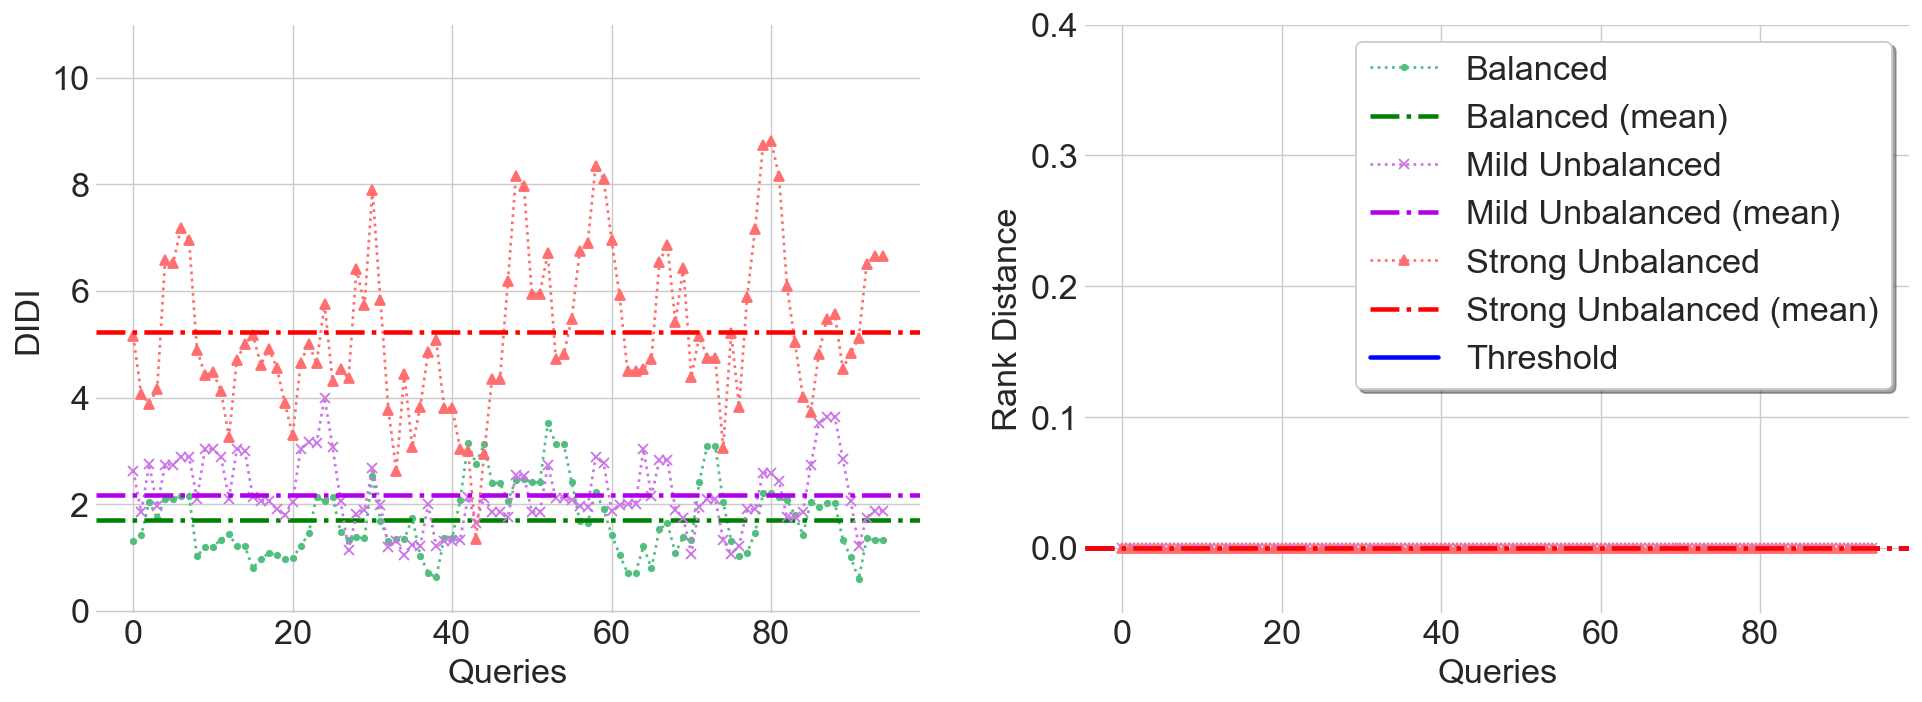

****************************************
EXP. 1
****************************************
balanced DIDI 1.5245392458386509
mild_unbalanced DIDI 1.8005116419731646
strong_unbalanced DIDI 3.226480157837505
balanced rank_dist 0.24040134736842106
mild_unbalanced rank_dist 0.25058402105263156
strong_unbalanced rank_dist 0.24894261052631578


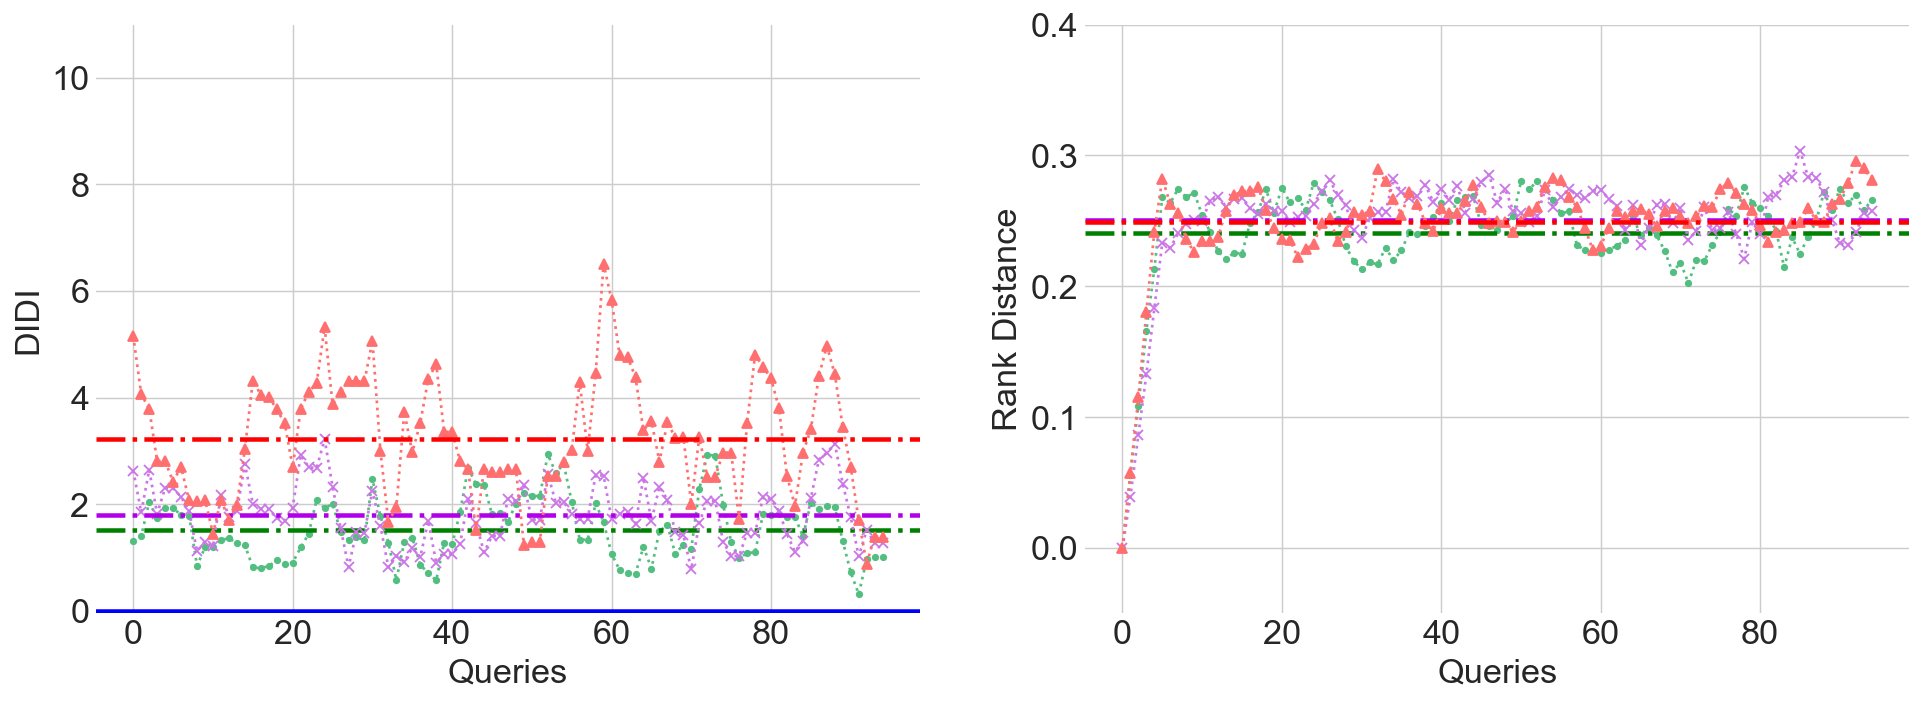

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


****************************************
EXP. 2
****************************************
balanced DIDI 1.702358904280333
mild_unbalanced DIDI 2.1767411843289137
strong_unbalanced DIDI 3.9880478737361504
balanced rank_dist 0.0
mild_unbalanced rank_dist 0.0
strong_unbalanced rank_dist 0.24711225263157893


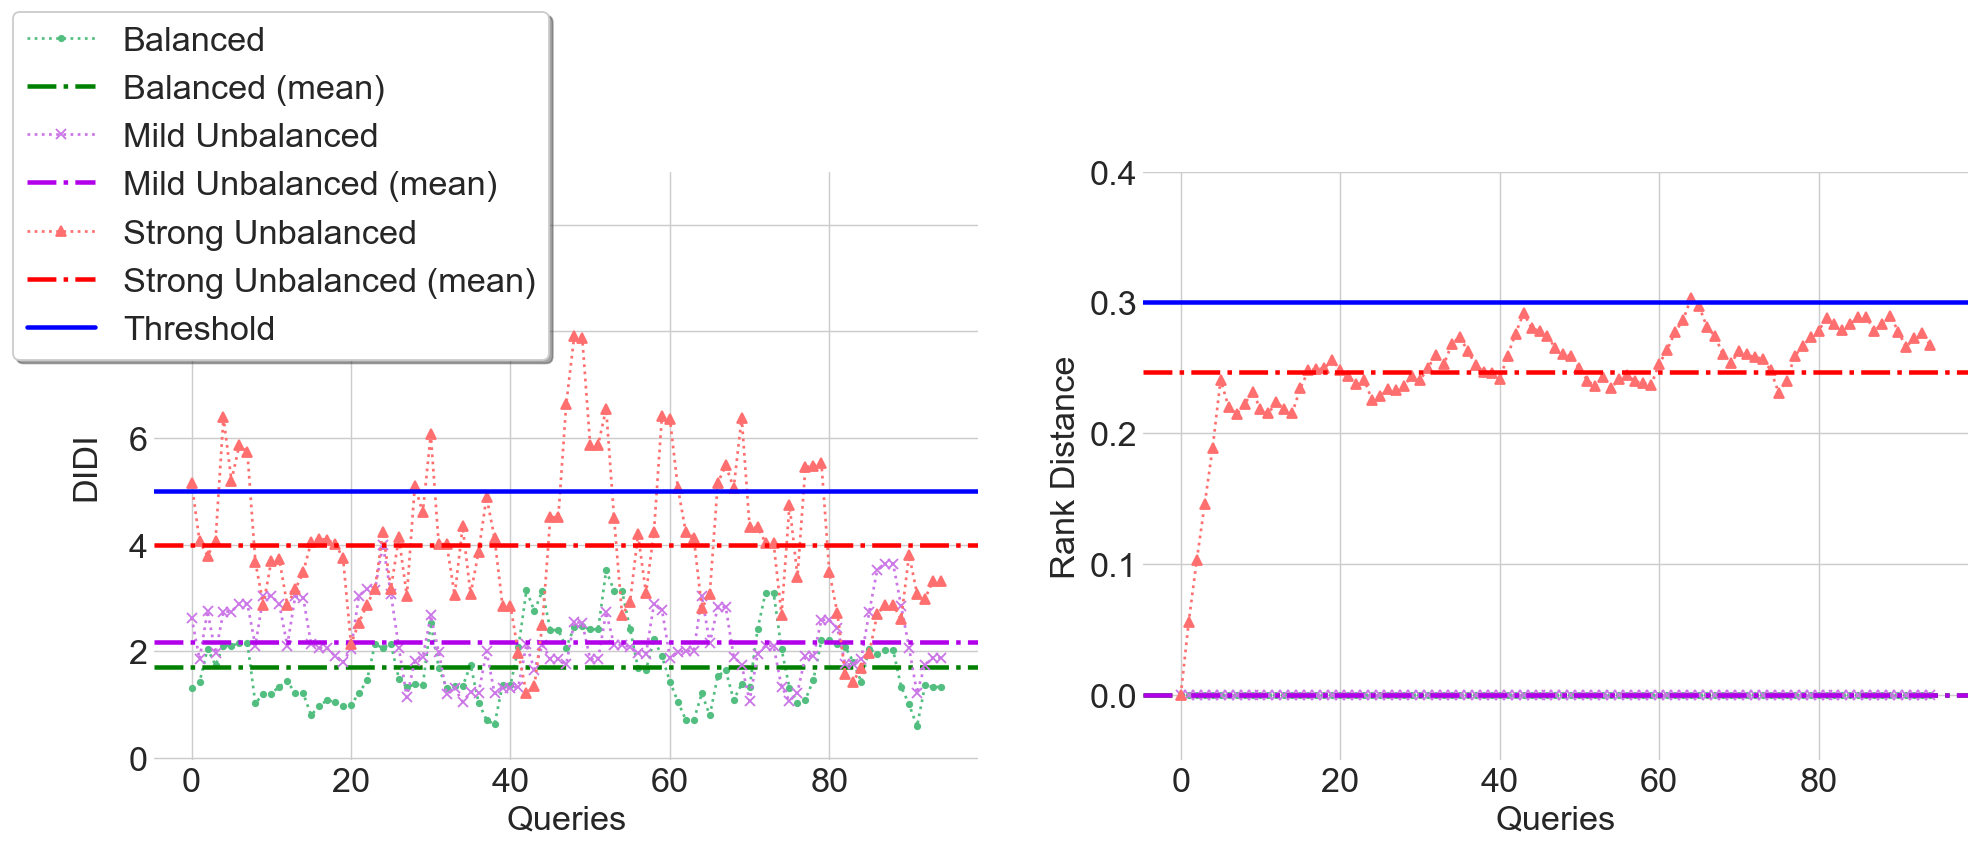

****************************************
EXP. 3
****************************************
balanced DIDI 1.6560411759820837
mild_unbalanced DIDI 1.9570537540783346
strong_unbalanced DIDI 4.171092705507671
balanced rank_dist 0.2380867368421053
mild_unbalanced rank_dist 0.24443724210526319
strong_unbalanced rank_dist 0.24778936842105262


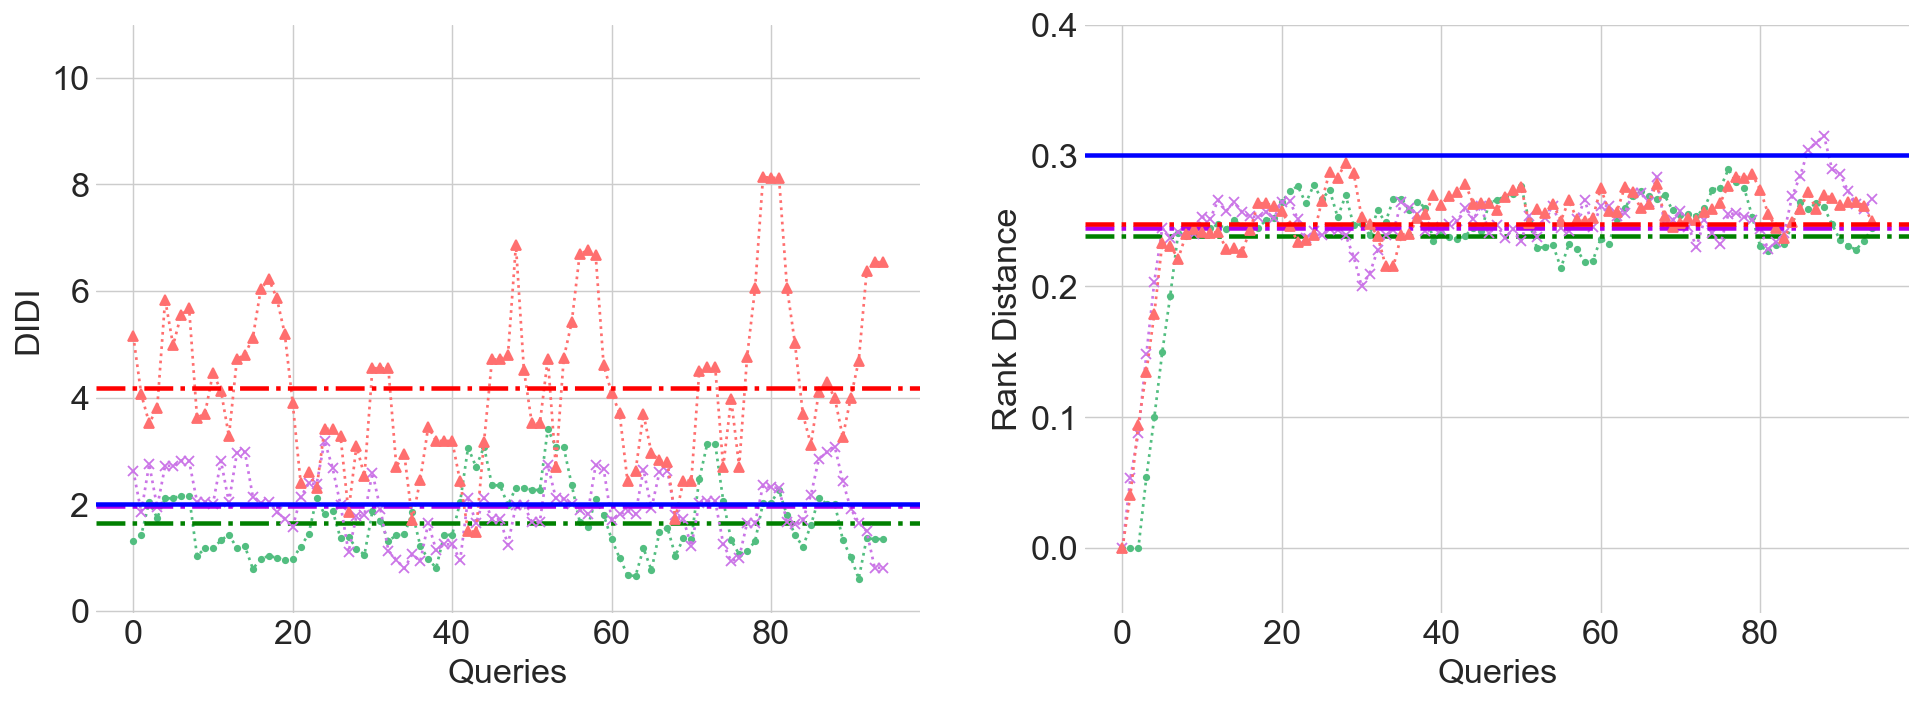

****************************************
EXP. 4
****************************************
balanced DIDI 1.5698590879696694
mild_unbalanced DIDI 2.0126580549987403
strong_unbalanced DIDI 4.4933705721116635
balanced rank_dist 0.24224882105263165
mild_unbalanced rank_dist 0.24715206315789473
strong_unbalanced rank_dist 0.24061134736842105


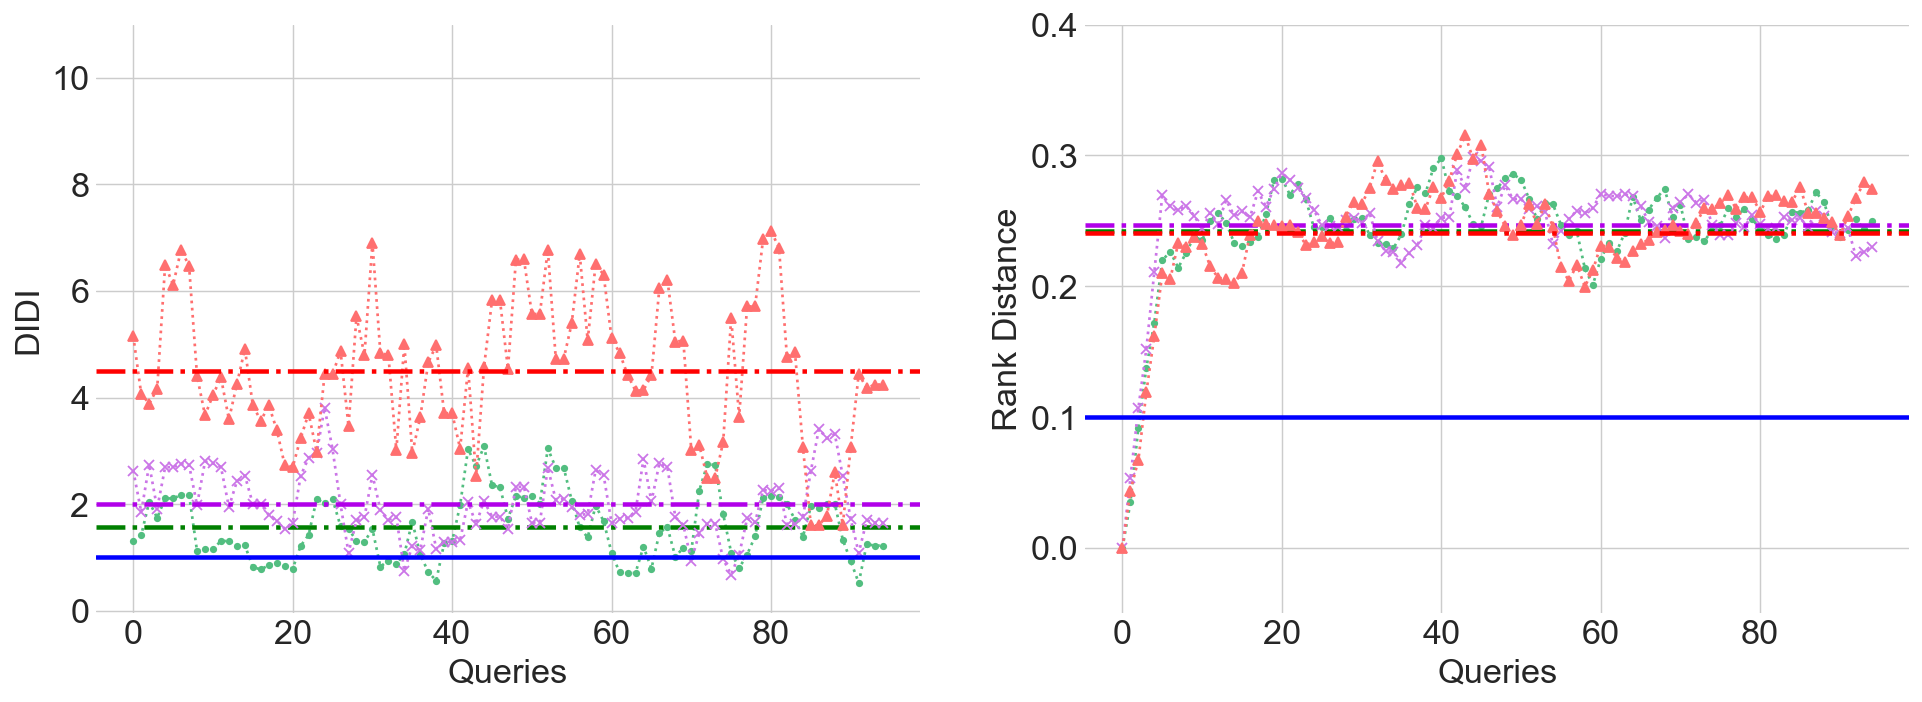

In [33]:
##### import matplotlib.pyplot as plt
plt.rcParams['font.size'] = 19
import seaborn as sns
sns.set_style('whitegrid')

imgpath = os.path.join(cd.PROJECT_DIR,'images', f'comparison/')

if not os.path.isdir(imgpath):
    os.makedirs(imgpath)
    
metrics_names= ['DIDI',
               'rank_dist']

colors = {'balanced':'green',
          'mild_unbalanced':'#b100e9',
          'strong_unbalanced':'red'}

lighter_colors = {'balanced':'#52be80',
          'mild_unbalanced':'#cb75e7',
          'strong_unbalanced':'#ff6f6f'}

markers = {'balanced':'.',
          'mild_unbalanced':'x',
          'strong_unbalanced':'^'}

for mu in mu_dict:
    print('*'*40)
    print('EXP.',mu)
    print('*'*40)
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18,6), dpi=130)
    fname = f'exp_{mu}.eps'
    # Loop on metrics
    for k, name in enumerate(metrics_names):
        if name=='rank_dist':
            name_ = 'Rank Distance'
        else:
            name_=name
        # Loop on dataset
        #for dataset in ['balanced','mild_unbalanced','strong_unbalanced']:
        for dataset in records.keys():
            if dataset=='mild_unbalanced':
                dt = 'Mild Unbalanced'
            elif dataset=='strong_unbalanced':
                dt = 'Strong Unbalanced'
            elif dataset=='balanced':
                dt = 'Balanced'
            rec = pd.DataFrame(records[dataset])
            n_sample = len(rec['provided_metrics'][mu][name])
            ma_actionable =  pd.Series(rec['provided_metrics'][mu][name])
            print(dataset, name, np.mean(rec['provided_metrics'][mu][name]))
            axes[k].plot(range(n_sample), 
                     ma_actionable,
                     marker=markers[dataset],
                     linestyle='dotted',
                     color=lighter_colors[dataset], 
                     label=f'{dt}')
            
            if name == 'rank_dist':
                axes[k].set_ylim(-0.05,.4)
            else:
                axes[k].set_ylim(-0.05,11)


            axes[k].axhline(y=np.mean(rec['provided_metrics'][mu][name]),
                        color=colors[dataset], 
                        linestyle='-.',
                        linewidth=2.5,
                        label=f'{dt} (mean)')
        if mu != 0:
            axes[k].axhline(y=mu_dict[mu][k], color='blue', linewidth=2.5, linestyle='-', label='Threshold')
        else:
            axes[k].axhline(y=np.inf, color='blue', linewidth=2.5, linestyle='-', label='Threshold')
        axes[k].set_xlabel('Queries')
        axes[k].set_ylabel(f'{name_}')
        if name == 'rank_dist' and mu==0:
            legend = axes[k].legend(loc='upper right',frameon=1, shadow=True)
            legend.get_frame().set_facecolor('white')
        elif name == 'DIDI' and mu==2:
            legend = axes[k].legend(bbox_to_anchor=(0.5,1.3),frameon=1, shadow=True)
            legend.get_frame().set_facecolor('white')
    plt.savefig(os.path.join(imgpath, fname), format='eps', bbox_inches="tight")
    plt.show()
plt.close('all')